In [663]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
from skimage.measure import label
# import sys
# np.set_printoptions(threshold=sys.maxsize)

In [664]:
cats = glob.glob('./Animals/Dogs/*')
dogs = glob.glob('./Animals/Cats/*')

In [665]:
cats[:5]

['./Animals/Dogs\\dog1.jpg',
 './Animals/Dogs\\dog10.jpg',
 './Animals/Dogs\\dog11.png',
 './Animals/Dogs\\dog12.jpg',
 './Animals/Dogs\\dog2.jpg']

In [666]:
dogs[:5]

['./Animals/Cats\\cat1.jpg',
 './Animals/Cats\\cat10.jpg',
 './Animals/Cats\\cat2.jpeg',
 './Animals/Cats\\cat3.webp',
 './Animals/Cats\\cat4.jpg']

# 9.1 Prepare HoG

In [667]:
warehouse = []
h,w = 200, 200
for path in cats + dogs:
    warehouse.append(img_to_array(load_img(path, target_size=(h,w))).astype('uint8')) # ,target_size=(h,w)

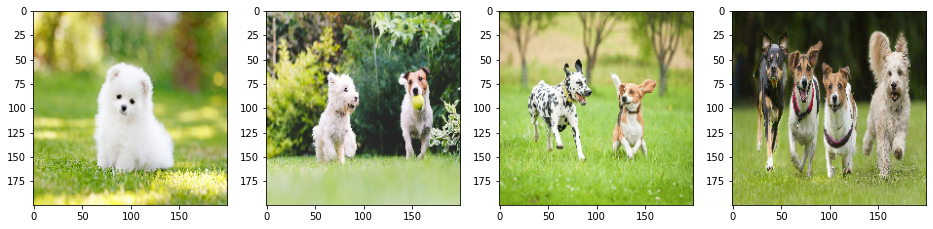

In [668]:
fig, axes = plt.subplots(1, 4, figsize=(16, 16))
for i in range(4):
    axes[i].imshow(warehouse[i])
plt.show()

In [669]:
blur = cv2.GaussianBlur(warehouse[0], (3, 3), 0) # size of blur
# blur = warehouse[0].copy() # no blur
fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, multichannel=True) # histogram of oriented gradients

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\skimage\_shared\utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


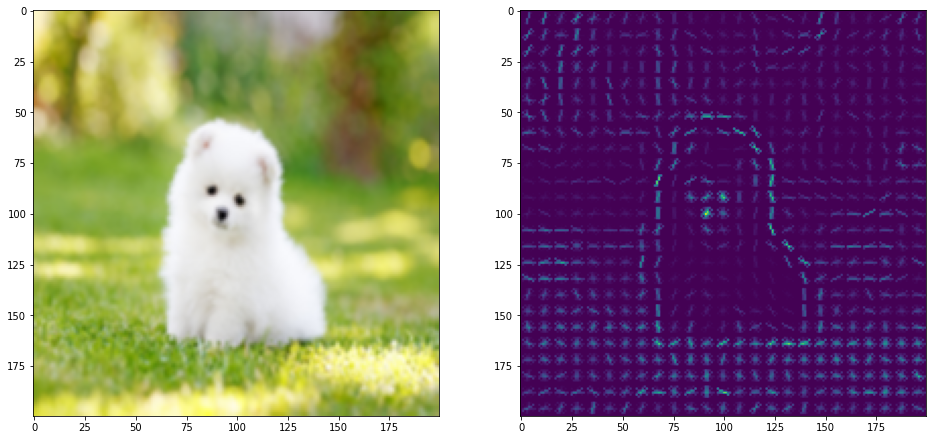

In [670]:
fig, axes = plt.subplots(1,2,figsize=(16,16))
axes[0].imshow(blur)
axes[1].imshow(hog_image)
plt.show()

### 9.1.2 Prepare HOG Feature of Subimages 

In [671]:
# subimages
Block_size = (80, 60) # (40,20) (40,30) (60,20) (60,30) (60,40)
Stride = (10, 10) # move pixel
posRow = np.arange(0, h - Block_size[0]+1, Stride[0])
posCol = np.arange(0, w - Block_size[1]+1, Stride[1])

In [672]:
#img = warehouse[0][:]
img = blur.copy()
hogfeatures = []
for i in posRow:
    for j in posCol:
        # startH = posRow[i]
        startH = i
        endH = startH + Block_size[0]
        startW = j
        endW = startW + Block_size[1]
        subImg = img[startH:endH, startW:endW, :]
        
        # blur = cv2.GaussianBlur(subImg,(5,5),0)
        fd, hog_image = hog(subImg, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, multichannel=True)
        hogfeatures.append(fd)

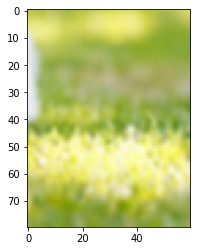

In [673]:
plt.imshow(subImg)

In [674]:
hogfeatures = np.array(hogfeatures)

# 9.2 KMean Clustering

In [675]:
hogfeatures = np.nan_to_num(hogfeatures, nan=0)

In [676]:
N = 2
kmeans = KMeans(n_clusters=N, random_state=0) # model # group with average (algorithm find avg)
clusters = kmeans.fit_predict(hogfeatures) # use train model

### 9.2.2 Region of Interest (RoI)

In [677]:
cluster_array = clusters.reshape(len(posRow), len(posCol)) # from subimages
print(cluster_array)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 1 1 1 0]
 [1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]]


In [678]:
# test = np.sum(cluster_array, axis=1)

In [679]:
# plt.hist(test)

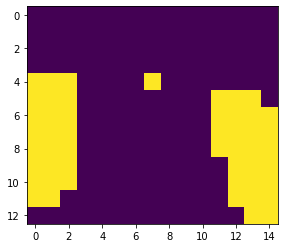

In [680]:
plt.imshow(cluster_array)

# 9.3 ROI: Drawing ROI bounding box

In [681]:
all_labels = label(cluster_array)
print(all_labels)
Color = (255,0,0) # red
Thickness = 1 # border

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 2 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 3 3 3 0]
 [1 1 1 0 0 0 0 0 0 0 0 3 3 3 3]
 [1 1 1 0 0 0 0 0 0 0 0 3 3 3 3]
 [1 1 1 0 0 0 0 0 0 0 0 3 3 3 3]
 [1 1 1 0 0 0 0 0 0 0 0 0 3 3 3]
 [1 1 1 0 0 0 0 0 0 0 0 0 3 3 3]
 [1 1 0 0 0 0 0 0 0 0 0 0 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 3]]


In [682]:
print(posCol.shape, posRow.shape)

(15,) (13,)


[0 1 2 3]


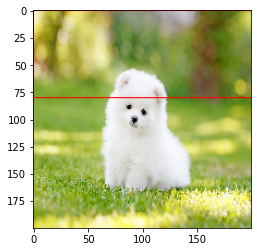

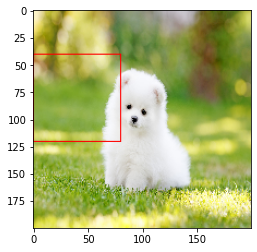

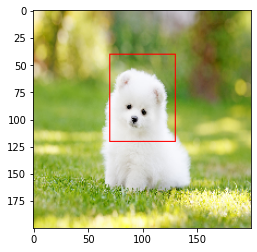

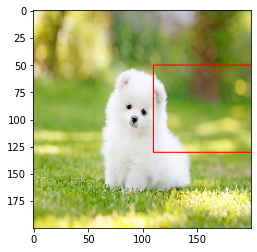

In [683]:
nClass = np.unique(all_labels)
print(nClass)

use_img = warehouse[0].copy()
ROIs = []
for i in nClass:
    objPos = np.argwhere(all_labels == i)
    startBlockH = objPos[:,0].min()
    endBlockH = objPos[:,0].max()
    startBlockW = objPos[:,1].min()
    endBlockW = objPos[:,1].max()
    startF = (posCol[startBlockW], posRow[startBlockH])
    endF = (posCol[endBlockW] + Block_size[1], posRow[startBlockH] + Block_size[0])
    _img = use_img.copy()
    ROIs.append(cv2.rectangle(_img, startF, endF, Color, Thickness).copy())
    plt.imshow(cv2.rectangle(_img, startF, endF, Color, Thickness).copy())
    plt.show()

In [684]:
len(ROIs)

4

In [685]:
# from mpl_toolkits.axes_grid1 import ImageGrid
# fig, axes = plt.subplots(1,len(ROIs),figsize=(16,10))
# for i in range(len(ROIs)):
#     axes[i].imshow(ROIs[i])
# plt.tight_layout()
# plt.show()

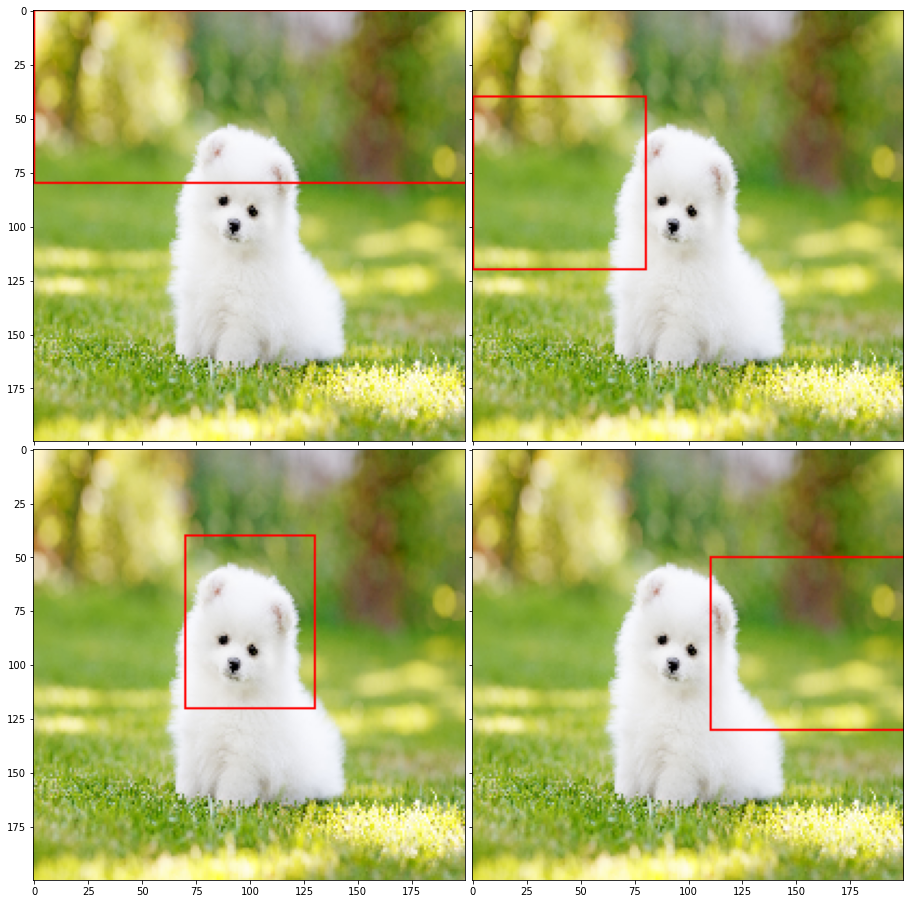

In [686]:
#use this one
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 16))
le = int(np.sqrt(len(ROIs))) # le -> length

# need to use Grid system to show image with red box
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(le, le),  # creates le x le grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, ROIs): # ROI consist of dog and red box
    # Iterating over the grid returns the Axes.
    ax.imshow(im.astype('uint8'))

plt.show()